## 1. Import des données

On s'intéresse maintenant à un problème bi-objectif ou les positions des offices sont des variables. Dans un premier temps, on veut optmiser les deux objectifs suivant: 
- distance totale
- workload des représentant

In [34]:
import gurobipy as gp
from gurobipy import GRB, quicksum
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

#Assignement initial des représnetant aux briques
initial_assignment = {
    4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 15: 1,   # SR 1
    10: 2, 11: 2, 12: 2, 13: 2, 14: 2,     # SR 2
    9: 3, 16: 3, 17: 3, 18: 3,             # SR 3
    1: 4, 2: 4, 3: 4, 19: 4, 20: 4, 21: 4, 22: 4  # SR 4
}

nbReps = 4
nbBlocks = 22

matrixInitAssignment = np.zeros((nbReps, nbBlocks), dtype=int)
for brique, rep in initial_assignment.items():
    matrixInitAssignment[rep - 1, brique - 1] = 1  # Ajustement 0-based

#Traitement du workload
workload_df = pd.read_csv("bricks_index_values.csv")
workload_df.drop(columns=["brick"], inplace=True)
workload_matrix = workload_df.to_numpy().T.flatten()  # shape (22,)

#Lecture du workload
dfWorkload = pd.read_csv("bricks_index_values.csv")
dfWorkload.drop(columns=["brick"], inplace=True)
arrayWorkloads = dfWorkload.to_numpy().T.flatten()  # shape (22,)

#Lecture des distances 
dfDistances = pd.read_excel("distances.xlsx", sheet_name="brick-brick", skiprows=1)

#Suppression éventuelle de colonnes inutiles
dfDistances = dfDistances.iloc[:, 2:]  #on garde seulement les colonnes distances
matrixDistances = dfDistances.to_numpy()  # shape (22,22)

# Accès facilité des center_bricks pour chaque représentant
dictInitialCenters = {1: 4, 2: 14, 3: 16, 4: 22}


## 2. Modèle bi-objectif

Dans cette cellule, nous allons définir la fonction `buildRelocationModel` qui crée et configure un **modèle Gurobi** :

- **Variables** :
  - `varAssign[rep, block]` (binaire) = 1 si la brique `block` est assignée au représentant `rep`.
  - `varCenter[rep, block]` (binaire) = 1 si la brique `block` est choisie comme “center/bureau” du représentant `rep`.
  - `varMaxLoad` (continue) = la charge de travail maximale parmi tous les représentants.

- **Fonction Objectif** :
  \[
    distance_totale + alpha * varMaxLoad
  \]
  où distance_totale est la somme des distances entre la brique bureau et les briques assignées.

- **Contraintes** :
  1. Chaque brique est affectée à un seul SR.
  2. Chaque SR choisit exactement 1 brique comme bureau.
  3. `varMaxLoad >= somme(workloads)` pour chaque SR.
  4. Calcul optionnel du nombre de bureaux relocalisés (`varNbRelocated`).

On renvoie le modèle et les variables pour manipulation ultérieure.


In [35]:
def buildRelocationModel(nbReps, nbBlocks, matrixDistances, arrayWorkloads, dictInitialCenters, alpha=0.05):
    """
    Paramètres :
    nbReps : int
        Nombre de représentants
    nbBlocks : int
        Nombre de briques
    matrixDistances : np.ndarray (nbBlocks x nbBlocks)
        Distances entre paires de briques
    arrayWorkloads : np.ndarray (nbBlocks, )
        Charge de travail de chaque brique (0-based)
    dictInitialCenters : dict
        Mapping SR -> brique center initial (notation 1-based)
    alpha : float
        Pondération de la charge max dans l'objectif
    """

    modelOpt = gp.Model("Relocation_Optimization")

    #Variables d'assignation
    varAssign = modelOpt.addVars(nbReps, nbBlocks, vtype=GRB.BINARY, name="Assign")

    #Variables de centre de bureau
    varCenter = modelOpt.addVars(nbReps, nbBlocks, vtype=GRB.BINARY, name="Center")

    #Variable continue pour la charge max
    varMaxLoad = modelOpt.addVar(name="MaxWorkload")

    # Calcul de la distance totale : sum_{rep,b,b'} matrixDistances[b', b] * varAssign[rep,b] * varCenter[rep,b']
    totalTravelDist = quicksum(
        matrixDistances[bureau, bloc] * varAssign[rep, bloc] * varCenter[rep, bureau]
        for rep in range(nbReps)
        for bloc in range(nbBlocks)
        for bureau in range(nbBlocks))

    #Objectif
    modelOpt.setObjective(totalTravelDist + alpha * varMaxLoad, GRB.MINIMIZE)

    #Contraintes
    for bloc in range(nbBlocks):
        modelOpt.addConstr(quicksum(varAssign[rep, bloc] for rep in range(nbReps)) == 1,name=f"OneRepPerBlock_{bloc}",)

    for rep in range(nbReps):
        modelOpt.addConstr(quicksum(varCenter[rep, bureau] for bureau in range(nbBlocks)) == 1,name=f"OneCenterPerRep_{rep}",)

    for rep in range(nbReps):
        modelOpt.addConstr(varMaxLoad>= quicksum(varAssign[rep, bloc] * arrayWorkloads[bloc] for bloc in range(nbBlocks)),name=f"MaxLoadRep_{rep}",)

    varNbRelocated = quicksum(1 - varCenter[rep, dictInitialCenters[rep + 1] - 1] for rep in range(nbReps))

    return modelOpt, varAssign, varCenter, totalTravelDist, varMaxLoad, varNbRelocated


## 3. Résolution via epsilon constraint

Ici, on applique la méthode epsilon constraint ou l’idée est de :

1. Résoudre une première fois le modèle.  
2. Tant qu’il reste **optimal**, ajouter une contrainte `varMaxLoad <= (valeur_courante - stepEpsilon)` pour forcer la recherche d’une nouvelle solution (ou déclarer l’insatisfaction).  
3. Collecter à chaque itération la distance totale, la charge max, et le nombre de bureaux relocalisés.  

On pourra ensuite tracer le **front de Pareto** Distance vs MaxWorkload.

In [36]:
def exploreParetoEpsilon(modelOpt,varAssign,varCenter,totalTravelDist,varMaxLoad,varNbRelocated,stepEpsilon):
    listeDistance = []
    listeMaxWork = []
    listeReloc = []

    modelOpt.Params.LogToConsole = 0
    modelOpt.optimize()

    while modelOpt.status == GRB.OPTIMAL:
        distActuelle = totalTravelDist.getValue()
        workloadActuel = varMaxLoad.X
        relocatedActuel = varNbRelocated.getValue()

        afficher_solution(modelOpt, varAssign, varCenter, totalTravelDist, varMaxLoad, varNbRelocated)

        #Stockage des résultats
        listeDistance.append(distActuelle)
        listeMaxWork.append(workloadActuel)
        listeReloc.append(relocatedActuel)

        #Ajout une contrainte plus stricte sur varMaxLoad
        newBound = workloadActuel - stepEpsilon
        modelOpt.addConstr(varMaxLoad <= newBound, name=f"EpsCon_{len(listeDistance)}")

        modelOpt.optimize()

    return listeDistance, listeMaxWork, listeReloc

In [37]:
def afficher_solution(modelOpt,varAssign,varCenter,totalTravelDist,varMaxLoad,varNbRelocated,matrixDistances=None,workloadArray=None,show_1_based=True,):

    sr_list = sorted(set(idx[0] for idx in varAssign.keys()))
    brick_list = sorted(set(idx[1] for idx in varAssign.keys()))

    dist_totale = totalTravelDist.getValue() if totalTravelDist is not None else None
    max_w = varMaxLoad.X if varMaxLoad is not None else None
    reloc = varNbRelocated.getValue() if varNbRelocated is not None else None
    obj_val = modelOpt.ObjVal

    print("\n===== SOLUTION COURANTE =====")

    for sr in sr_list:
        # Trouver la brique center
        center_blocks = [b for b in brick_list if varCenter[sr, b].X > 0.5]
        if len(center_blocks) == 1:
            center_b = center_blocks[0]
        else:
            center_b = None  # Cas improbable si le modèle est correct

        # Liste des briques assignées
        assigned_bricks = [b for b in brick_list if varAssign[sr, b].X > 0.5]

        # Calcul distance cumulée pour ce SR (si on a matrixDistances et un center)
        sr_distance = 0.0
        if matrixDistances is not None and center_b is not None:
            for b_assigned in assigned_bricks:
                sr_distance += matrixDistances[center_b, b_assigned]

        # Calcul de la charge cumulée pour ce SR (si on a workloadArray)
        sr_workload = 0.0
        if workloadArray is not None:
            for b_assigned in assigned_bricks:
                sr_workload += workloadArray[b_assigned]

        # Ajustement d'indices en 1-based si besoin
        if show_1_based:
            sr_disp = sr + 1
            center_disp = (center_b + 1) if center_b is not None else None
            assigned_disp = [b + 1 for b in assigned_bricks]
        else:
            sr_disp = sr
            center_disp = center_b
            assigned_disp = assigned_bricks

        # Affichage
        print(f"[SR {sr_disp}] ")
        print(f"  - Center : {center_disp}")
        print(f"  - Briques assignées : {assigned_disp}")
        if matrixDistances is not None:
            print(f"  - Distance cumulée : {sr_distance:.3f}")
        if workloadArray is not None:
            print(f"  - Workload cumulée : {sr_workload:.3f}")
        print("")

    print("===== INDICATEURS GLOBAUX =====")
    if dist_totale is not None:
        print(f" - Distance totale   : {dist_totale:.3f}")
    if max_w is not None:
        print(f" - Max workload      : {max_w:.3f}")
    if reloc is not None:
        print(f" - Bureaux relocalisés : {reloc:.0f}")
    print(f" - Valeur de l'objectif : {obj_val:.3f}")

    print("================================\n")


## 4 Plot des résultats

Set parameter LogToConsole to value 0

===== SOLUTION COURANTE =====
[SR 1] 
  - Center : 2
  - Briques assignées : [1, 2, 3, 19, 20, 21, 22]

[SR 2] 
  - Center : 12
  - Briques assignées : [12]

[SR 3] 
  - Center : 6
  - Briques assignées : [4, 5, 6, 7, 8, 9]

[SR 4] 
  - Center : 15
  - Briques assignées : [10, 11, 13, 14, 15, 16, 17, 18]

===== INDICATEURS GLOBAUX =====
 - Distance totale   : 88.302
 - Max workload      : 2.160
 - Bureaux relocalisés : 4
 - Valeur de l'objectif : 88.323


===== SOLUTION COURANTE =====
[SR 1] 
  - Center : 2
  - Briques assignées : [1, 2, 3, 19, 20, 21, 22]

[SR 2] 
  - Center : 15
  - Briques assignées : [10, 11, 14, 15, 16, 17, 18]

[SR 3] 
  - Center : 6
  - Briques assignées : [4, 5, 6, 7, 8, 9, 13]

[SR 4] 
  - Center : 12
  - Briques assignées : [12]

===== INDICATEURS GLOBAUX =====
 - Distance totale   : 90.939
 - Max workload      : 2.062
 - Bureaux relocalisés : 4
 - Valeur de l'objectif : 90.960


===== SOLUTION COURANTE =====
[SR 1] 
  -

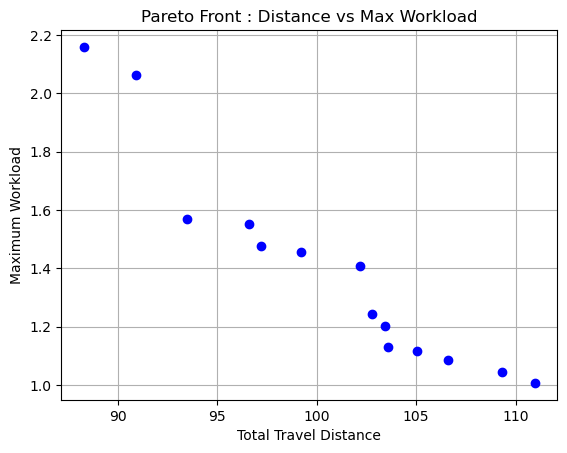

In [38]:
modelOptimization, varAssign, varCenter, exprTotalDist, exprMaxLoad, exprRelocCount = (buildRelocationModel(nbReps=nbReps,nbBlocks=nbBlocks,matrixDistances=matrixDistances,arrayWorkloads=arrayWorkloads,dictInitialCenters=dictInitialCenters,alpha=0.01,))

listDist, listWork, listReloc = exploreParetoEpsilon(modelOptimization,varAssign,varCenter,exprTotalDist,exprMaxLoad,exprRelocCount,stepEpsilon=0.01,)


# Créer le dossier plots s'il n'existe pas
if not os.path.exists('plots'):
    os.makedirs('plots')
    
plt.figure()
plt.plot(listDist, listWork, "o", color="blue")
plt.xlabel("Total Travel Distance")
plt.ylabel("Maximum Workload")
plt.title("Pareto Front : Distance vs Max Workload")
plt.grid(True)
plt.savefig("plots/step3_bi_objectif.png")
plt.show()